___

In [1]:
# Import libraries to be used

# Warning messages display
# import warnings
# warnings.filterwarnings(action='once') # https://docs.python.org/3/library/warnings.html#the-warnings-filter

# Directories/Files management
import os.path
## from zipfile import ZipFile # De momento no ha hecho falta 

# Timing
import time

# Data analysis and wrangling
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None) # Show all columns in DataFrames
pd.set_option('display.max_rows', 100) # If too high, it greatly slows down the output display and freezes the kernel


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot') # choose a style: 'plt.style.available'
sns.set_theme(context='notebook',
              style="darkgrid") # {darkgrid, whitegrid, dark, white, ticks}
palette = sns.color_palette("flare", as_cmap=True);
import altair as alt

# Machine Learning
## from sklearn.[...] import ...

In [2]:
%load_ext memory_profiler

In [3]:
t0 = time.perf_counter() 

In [4]:
# Detect Operating System running and manage paths accordingly

if os.name == 'nt': # Windows
    root = r"C:\Users\turge\CompartidoVM\0.TFM"
    print("Running on Windows.")
elif os.name == 'posix': # Ubuntu
    root = "/home/dsc/shared/0.TFM"
    print("Running on Ubuntu.")
print("root path\t", root)

Running on Windows.
root path	 C:\Users\turge\CompartidoVM\0.TFM


___

## 1. Load the dataset

In [5]:
cols = [
 'MONTH',
 'DAY_OF_MONTH',
 'DAY_OF_WEEK',
 'OP_UNIQUE_CARRIER',
 'ORIGIN',
#  'WBAN_Origin_OTP', # Redundant having the 'ORIGIN' feature
 'DEST',
#  'WBAN_Dest_OTP', # Redundant having the 'DEST' feature
 'DEP_TIME_hour',
 'TAXI_OUT_median',
 'TAXI_IN_median',
 'ARR_TIME_hour',
 'CRS_ELAPSED_TIME',
 'DISTANCE',
#  'DISTANCE_GROUP', # Redundant having the 'DISTANCE' feature
#  'STATION_Origin', # Redundant having the 'ORIGIN' feature
#  'WMO_Origin', # Redundant having the 'ORIGIN' feature
#  'WBAN_Origin_LCD', # Redundant having the 'ORIGIN' feature
 'HourlyAltimeterSetting_Origin',
 'HourlyDryBulbTemperature_Origin',
 'HourlyPrecipitation_Origin',
 'HourlyRelativeHumidity_Origin',
 'HourlySkyConditions_Origin',
 'HourlyVisibility_Origin',
#  'REM_Origin', # Not relevant for the model
#  'STATION_Dest', # Redundant having the 'DEST' feature
#  'WMO_Dest', # Redundant having the 'DEST' feature
#  'WBAN_Dest_LCD', # Redundant having the 'DEST' feature
 'HourlyAltimeterSetting_Dest',
 'HourlyDryBulbTemperature_Dest',
 'HourlyPrecipitation_Dest',
 'HourlyRelativeHumidity_Dest',
 'HourlySkyConditions_Dest',
 'HourlyVisibility_Dest',
#  'REM_Dest', # Redundant having the 'ORIGIN' feature
 'ARR_DEL15' # → Target !!
]

In [6]:
preprocessed_input_csv_path = os.path.join(root,
                                           "Output_Data",
                                           "US_DoT-NOAA",
                                           "OTP_LCD_allColumns.csv")
preprocessed_input_csv_path

'C:\\Users\\turge\\CompartidoVM\\0.TFM\\Output_Data\\US_DoT-NOAA\\OTP_LCD_allColumns.csv'

In [7]:
%%time

df_all = pd.read_csv(preprocessed_input_csv_path,
                     encoding='latin1',
                     usecols=cols,
                     dtype={
                            'MONTH' : 'string',
                            'DAY_OF_MONTH' : 'string',
                            'DAY_OF_WEEK' : 'string',
                            'OP_UNIQUE_CARRIER' : 'string',
                            'ORIGIN' : 'string',
                            'DEST' : 'string',
                            'DEP_TIME_hour' : 'string',
                            'TAXI_OUT_median' : 'int32',
                            'TAXI_IN_median' : 'int32',
                            'ARR_TIME_hour' : 'string',
                            'CRS_ELAPSED_TIME' : 'int32',
                            'DISTANCE' : 'int32',
                            'HourlyAltimeterSetting_Origin' : 'float32',
                            'HourlyDryBulbTemperature_Origin' : 'float32',
                            'HourlyPrecipitation_Origin' : 'float32',
                            'HourlyRelativeHumidity_Origin' : 'float32',
                            'HourlySkyConditions_Origin' : 'string',
                            'HourlyVisibility_Origin' : 'float32',
                            'HourlyAltimeterSetting_Dest' : 'float32',
                            'HourlyDryBulbTemperature_Dest' : 'float32',
                            'HourlyPrecipitation_Dest' : 'float32',
                            'HourlyRelativeHumidity_Dest' : 'float32',
                            'HourlySkyConditions_Dest' : 'string',
                            'HourlyVisibility_Dest' : 'float32',
                            'ARR_DEL15' : 'int32'
                           }
                    )
df_all.sample(5)

Wall time: 1min 2s


,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME_hour,TAXI_OUT_median,TAXI_IN_median,ARR_DEL15,ARR_TIME_hour,CRS_ELAPSED_TIME,DISTANCE,HourlyAltimeterSetting_Origin,HourlyDryBulbTemperature_Origin,HourlyPrecipitation_Origin,HourlyRelativeHumidity_Origin,HourlySkyConditions_Origin,HourlyVisibility_Origin,HourlyAltimeterSetting_Dest,HourlyDryBulbTemperature_Dest,HourlyPrecipitation_Dest,HourlyRelativeHumidity_Dest,HourlySkyConditions_Dest,HourlyVisibility_Dest
2410576,12,16,1,9E,MCI,LGA,11,15,8,0,15,166,1107,30.170000,23.0,0.0,81.0,OVC,2.50,30.219999,37.0,0.0,44.0,OVC,10.0
2945731,11,18,1,WN,TPA,FLL,10,10,7,0,11,70,197,29.905001,63.0,0.0,65.0,(missing),9.94,29.879999,63.0,0.0,78.0,BKN,10.0
4899250,10,03,4,OH,PHL,ORF,20,19,3,0,21,66,212,29.969999,64.0,0.0,93.0,OVC,3.00,29.959999,75.0,0.0,90.0,OVC,7.0
1518996,06,24,1,NK,DFW,MCO,16,16,11,0,20,168,985,29.870001,84.0,0.0,65.0,BKN,10.00,30.020000,87.0,0.0,53.0,FEW,10.0
1342857,05,26,7,WN,SAN,DEN,10,12,6,0,13,135,853,30.010000,62.0,0.0,65.0,(missing),9.94,29.860001,73.0,0.0,48.0,BKN,10.0


In [8]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200051 entries, 0 to 7200050
Data columns (total 25 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   MONTH                            string 
 1   DAY_OF_MONTH                     string 
 2   DAY_OF_WEEK                      string 
 3   OP_UNIQUE_CARRIER                string 
 4   ORIGIN                           string 
 5   DEST                             string 
 6   DEP_TIME_hour                    string 
 7   TAXI_OUT_median                  int32  
 8   TAXI_IN_median                   int32  
 9   ARR_DEL15                        int32  
 10  ARR_TIME_hour                    string 
 11  CRS_ELAPSED_TIME                 int32  
 12  DISTANCE                         int32  
 13  HourlyAltimeterSetting_Origin    float32
 14  HourlyDryBulbTemperature_Origin  float32
 15  HourlyPrecipitation_Origin       float32
 16  HourlyRelativeHumidity_Origin    float32
 17  HourlySk

## 2. Dataset overview

In [9]:
# For deterministic purposes, let's define a seed:
np.random.seed(0)

In [10]:
# For the initial runs, define a reasonably-sized sample:
sample_length = int(1e5)

# The dataset is somehow imbalanced (80% on-time / 20% delayed), so let's perform some quick undersampling:
delayed = df_all[df_all['ARR_DEL15'] == 1].sample(sample_length // 2)
ontime = df_all[df_all['ARR_DEL15'] == 0].sample(sample_length // 2)
df = delayed.append(ontime)

# Get dummies for the categorical features:
# df = pd.get_dummies(data=df, columns=df.select_dtypes('category').columns)

print("On-time flights: {:7d} ({:5.2f}%)".format(len(ontime), 100*len(ontime)/len(df)))
print("Delayed flights: {:7d} ({:5.2f}%)".format(len(delayed), 100*len(delayed)/len(df)))

On-time flights:   50000 (50.00%)
Delayed flights:   50000 (50.00%)


### Train / Test / Validation split
Break the dataset into three blocks:
1. Training (70%)
2. Test (15%)
3. Validation (15%)

In [11]:
def target_encoder(df, column, target, index=None, method='mean'):
    """
    Target-based encoding is numerization of a categorical variables via the target variable. Main purpose is to deal
    with high cardinality categorical features without exploding dimensionality. This replaces the categorical variable
    with just one new numerical variable. Each category or level of the categorical variable is represented by a
    summary statistic of the target for that level.
    Args:
        df (pandas df): Pandas DataFrame containing the categorical column and target.
        column (str): Categorical variable column to be encoded.
        target (str): Target on which to encode.
        index (arr): Can be supplied to use targets only from the train index. Avoids data leakage from the test fold
        method (str): Summary statistic of the target. Mean, median or std. deviation.
    Returns:
        arr: Encoded categorical column.
    """

    index = df.index if index is None else index # Encode the entire input df if no specific indices is supplied

    if method == 'mean':
        encoded_column = df[column].map(df.iloc[index].groupby(column)[target].mean())
    elif method == 'median':
        encoded_column = df[column].map(df.iloc[index].groupby(column)[target].median())
    elif method == 'std':
        encoded_column = df[column].map(df.iloc[index].groupby(column)[target].std())
    else:
        raise ValueError("Incorrect method supplied: '{}'. Must be one of 'mean', 'median', 'std'".format(method))

    return encoded_column

In [12]:
df.select_dtypes('string').columns

Index(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'ORIGIN',
       'DEST', 'DEP_TIME_hour', 'ARR_TIME_hour', 'HourlySkyConditions_Origin',
       'HourlySkyConditions_Dest'],
      dtype='object')

In [13]:
# Divide the data:
train_idx = df.sample(frac=0.7).index
for c in df.select_dtypes('string').columns:
    df[c] = target_encoder(df_all, column=c, target='ARR_DEL15', index=train_idx, method='mean')
train = df.loc[train_idx, :]
test_valid = df.drop(train.index)
test = test_valid.sample(frac=0.5)
valid = test_valid.drop(test.index)

print("Total dataset:      {:7d} ({:6.2f}%)".format(len(df), 100*len(df)/len(df)))
print("Training dataset:   {:7d} ( {:5.2f}%)".format(len(train), 100*len(train)/len(df)))
print("Test dataset:       {:7d} ( {:5.2f}%)".format(len(test), 100*len(test)/len(df)))
print("Validation dataset: {:7d} ( {:5.2f}%)".format(len(valid), 100*len(valid)/len(df)))

Total dataset:       100000 (100.00%)
Training dataset:     70000 ( 70.00%)
Test dataset:         15000 ( 15.00%)
Validation dataset:   15000 ( 15.00%)


In [14]:
train.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME_hour,TAXI_OUT_median,TAXI_IN_median,ARR_DEL15,ARR_TIME_hour,CRS_ELAPSED_TIME,DISTANCE,HourlyAltimeterSetting_Origin,HourlyDryBulbTemperature_Origin,HourlyPrecipitation_Origin,HourlyRelativeHumidity_Origin,HourlySkyConditions_Origin,HourlyVisibility_Origin,HourlyAltimeterSetting_Dest,HourlyDryBulbTemperature_Dest,HourlyPrecipitation_Dest,HourlyRelativeHumidity_Dest,HourlySkyConditions_Dest,HourlyVisibility_Dest
2826907,0.520539,0.516886,0.504773,0.532167,0.561085,0.460714,0.442821,16,8,0,0.478123,188,1121,29.980000,92.0,0.0,41.0,0.500951,10.0,29.969999,88.0,0.0,63.0,0.507303,10.0
2195818,0.411909,0.468778,0.497350,0.536646,0.542289,0.531395,0.408000,16,7,0,0.432102,144,862,30.040001,13.0,0.0,81.0,0.500951,10.0,30.120001,68.0,0.0,25.0,0.507303,10.0
1813896,0.520539,0.568823,0.475541,0.532167,0.534831,0.610897,0.408000,16,6,0,0.428571,181,1096,30.090000,86.0,0.0,59.0,0.500951,10.0,30.070000,86.0,0.0,46.0,0.507303,10.0
3829615,0.489591,0.505106,0.510436,0.532167,0.518961,0.512614,0.326435,15,12,0,0.310966,184,985,30.110001,71.0,0.0,90.0,0.486947,10.0,29.930000,67.0,0.0,79.0,0.465469,10.0
6421377,0.555044,0.488803,0.533464,0.354839,0.407895,0.408624,0.609571,8,7,1,0.588211,39,100,29.889999,75.0,0.0,84.0,0.451483,10.0,29.920000,73.0,0.0,66.0,0.454976,10.0


# XGBoost

In [15]:
from xgboost import XGBClassifier

In [16]:
# Train / Test partition:
X_train, y_train = train.drop("ARR_DEL15", axis=1), train["ARR_DEL15"]
X_test, y_test = test.drop("ARR_DEL15", axis=1), test["ARR_DEL15"]

# Validation:
X_valid, y_valid = valid.drop("ARR_DEL15", axis=1), valid["ARR_DEL15"]

`num_boost_round`: corresponds to the number of boosting rounds or trees to build
- Its optimal value highly depends on the other parameters, and thus it should be re-tuned each time you update a parameter.
- You could do this by tuning it together with all parameters in a grid-search, but it requires a lot of computational effort.
- Fortunately XGBoost provides a nice way to find the best number of rounds whilst training.
- We can test our model at each step and see if adding a new tree/round improves performance.
- If performance haven’t improved for N rounds (N is defined by the variable `early_stopping_round`), we stop the training and keep the best number of boosting rounds.

In [17]:
# Basic model definition:
xgb_model = XGBClassifier(use_label_encoder=False, verbosity=1, random_state=0, objective= 'binary:logistic',
                          booster='gbtree', tree_method='auto', num_boost_round = 999, early_stopping_round=10)

params = {
            'min_child_weight': [0.1, 1, 5, 10, 50],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [5, 10, 25, 50],
            'learning_rate': [0.0001, 0.001, 0.1, 1],
            'n_estimators': [50, 100, 250, 500],
            'reg_alpha': [0.0001, 0.001, 0.1, 1],
            'reg_lambda': [0.0001, 0.001, 0.1, 1]
        }

## Training

Info: https://stackoverflow.com/questions/51587535/custom-evaluation-function-based-on-f1-for-use-in-xgboost-python-api

In [18]:
from sklearn.metrics import f1_score

def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1 - f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

In [19]:
# Source: https://github.com/dask/dask-searchcv/issues/51
# Info: https://ml.dask.org/modules/generated/dask_ml.model_selection.RandomizedSearchCV.html

from dask_ml.model_selection import RandomizedSearchCV
from dask.diagnostics import ProgressBar

dask_rscv = RandomizedSearchCV(xgb_model, 
                                   cv=5,
                                   param_distributions=params, 
                                   n_iter=10, # Number of parameter settings that are sampled → trades off runtime vs quality
                                   scoring='recall', 
                                   n_jobs=-2, # all CPUs but one are used
                                   random_state=1001)

with ProgressBar():
    dask_rscv.fit(X=X_train, y=y_train)

[########################################] | 100% Completed | 20min  5.2s
[########################################] | 100% Completed | 42.8s


In [20]:
cv_res = pd.DataFrame(dask_rscv.cv_results_)
cv_res

,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,param_subsample,param_reg_lambda,param_reg_alpha,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree
0,"{'subsample': 0.8, 'reg_lambda': 0.0001, 'reg_...",24.255968,1.805743,0.116850,0.023874,0.631571,0.614571,0.621571,0.614000,0.610341,0.618411,0.007517,6,0.8,0.0001,0.001,250,0.1,5,0.001,0.5,0.8
1,"{'subsample': 0.8, 'reg_lambda': 0.0001, 'reg_...",78.636207,4.561312,0.280161,0.063769,0.654143,0.653000,0.639571,0.645429,0.644194,0.647267,0.005517,1,0.8,0.0001,0.1,100,1,25,0.001,2,0.6
2,"{'subsample': 0.8, 'reg_lambda': 0.0001, 'reg_...",38.006386,1.734369,0.101474,0.026853,0.647286,0.650857,0.640286,0.639286,0.642622,0.644067,0.004375,3,0.8,0.0001,0.001,100,50,25,0.1,2,1
3,"{'subsample': 1.0, 'reg_lambda': 0.0001, 'reg_...",292.448327,6.236555,0.591573,0.103448,0.643429,0.638429,0.626429,0.638571,0.630767,0.635525,0.006092,4,1,0.0001,0.001,500,10,50,0.001,1.5,0.8
4,"{'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha...",105.835103,8.688950,0.178700,0.010443,0.652000,0.649714,0.641571,0.644571,0.644622,0.646496,0.003798,2,0.8,1,1,250,10,50,0.0001,5,0.6
5,"{'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha...",26.099252,1.172361,0.097113,0.021886,0.640286,0.636143,0.624143,0.629000,0.628767,0.631668,0.005770,5,1,1,0.1,50,10,25,0.001,1,0.8
6,"{'subsample': 0.8, 'reg_lambda': 0.001, 'reg_a...",34.644196,1.065055,0.082573,0.006208,0.627714,0.618857,0.598286,0.605714,0.615198,0.613154,0.010248,8,0.8,0.001,0.1,100,1,10,0.001,1,1
7,"{'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alp...",86.266071,2.735365,0.146722,0.005606,0.608714,0.611000,0.600857,0.593000,0.614912,0.605697,0.007833,9,1,0.1,0.0001,250,50,25,1,2,0.8
8,"{'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alp...",27.439341,0.493045,0.079732,0.009709,0.585143,0.578429,0.578714,0.564571,0.582060,0.577783,0.007047,10,0.6,0.1,0.1,100,0.1,10,1,1,1
9,"{'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha...",6.136419,0.183654,0.055956,0.008807,0.616857,0.619286,0.618714,0.606286,0.604914,0.613211,0.006282,7,1,1,0.1,50,10,5,1,1,1


In [21]:
dask_rscv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, early_stopping_round=10,
              gamma=2, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.001, max_delta_step=0,
              max_depth=25, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_boost_round=999, num_parallel_tree=1, random_state=0,
              reg_alpha=0.1, reg_lambda=0.0001, scale_pos_weight=1,
              subsample=0.8, tree_method='auto', use_label_encoder=False,
              validate_parameters=1, verbosity=1)

In [22]:
dask_rscv.best_score_

0.6472673087518109

In [23]:
dask_rscv.best_params_

{'subsample': 0.8,
 'reg_lambda': 0.0001,
 'reg_alpha': 0.1,
 'n_estimators': 100,
 'min_child_weight': 1,
 'max_depth': 25,
 'learning_rate': 0.001,
 'gamma': 2,
 'colsample_bytree': 0.6}

In [24]:
dask_rscv.best_index_

1

In [25]:
dask_rscv.scorer_

make_scorer(recall_score, average=binary)

In [26]:
dask_rscv.get_params

<bound method BaseEstimator.get_params of RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_round=10, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constr...
                                           verbosity=1),
                   n_jobs=-2,
                   param_distributions={'colsample_b

In [27]:
dask_rscv.predict(X_test)

array([1, 0, 1, ..., 0, 1, 1])

In [28]:
dask_rscv.predict_proba(X_test)

array([[0.49848616, 0.50151384],
       [0.51520765, 0.48479232],
       [0.49527872, 0.5047213 ],
       ...,
       [0.5230175 , 0.47698244],
       [0.4832605 , 0.5167395 ],
       [0.49164772, 0.5083523 ]], dtype=float32)

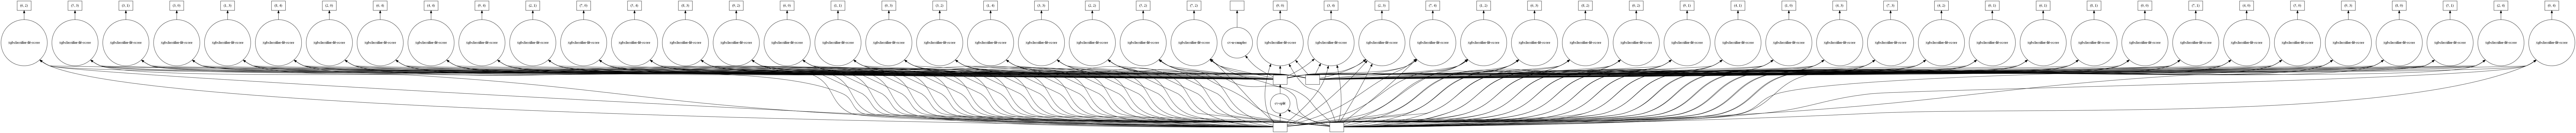

In [29]:
dask_rscv.visualize(filename='dask_rscv_23', format='png')

In [30]:
best_dask_rscv = dask_rscv.best_estimator_
best_dask_rscv

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, early_stopping_round=10,
              gamma=2, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.001, max_delta_step=0,
              max_depth=25, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_boost_round=999, num_parallel_tree=1, random_state=0,
              reg_alpha=0.1, reg_lambda=0.0001, scale_pos_weight=1,
              subsample=0.8, tree_method='auto', use_label_encoder=False,
              validate_parameters=1, verbosity=1)

## Evaluation

### Additional metrics results

In [31]:
# Evaluate the model's metrics:

from sklearn.metrics import fbeta_score, f1_score, recall_score, precision_score, accuracy_score, \
                            confusion_matrix, classification_report, roc_curve, roc_auc_score, plot_roc_curve

def clf_metrics(classifier, y_test, y_pred):
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print("Normalized confusion matrix:\n", confusion_matrix(y_test, y_pred, normalize='true'), '\n')
    print(classification_report(y_test, y_pred, target_names=['on-time', 'delayed']))
    print("F-beta (ß=2) = {:6.3f}".format(fbeta_score(y_test, y_pred, beta=2)))   
    print("F1 =           {:6.3f}".format(f1_score(y_test, y_pred)))   
    print("Recall =       {:6.3f}".format(recall_score(y_test, y_pred)))   
    print("Precision =    {:6.3f}".format(precision_score(y_test, y_pred)))   
    print("Accuracy =     {:6.3f}".format(accuracy_score(y_test, y_pred)))

### Test

In [32]:
y_train_pred = best_dask_rscv.predict(X_train)
y_test_pred = best_dask_rscv.predict(X_test)
y_valid_pred = best_dask_rscv.predict(X_valid)
y_test_pred

array([1, 0, 1, ..., 0, 1, 1])

In [33]:
print("-+-+-+ TRAINING dataset +-+-+-\n")
clf_metrics(best_dask_rscv, y_train, y_train_pred)
print("-------------------------------------------------------\n")
print("-+-+-+ TEST dataset: +-+-+-\n")
clf_metrics(best_dask_rscv, y_test, y_test_pred)
print("-------------------------------------------------------\n")
print("-+-+-+ VALIDATION dataset: +-+-+-\n")
clf_metrics(best_dask_rscv, y_valid, y_valid_pred)

-+-+-+ TRAINING dataset +-+-+-

Confusion matrix:
 [[34785   214]
 [  345 34656]]
Normalized confusion matrix:
 [[0.99388554 0.00611446]
 [0.00985686 0.99014314]] 

              precision    recall  f1-score   support

     on-time       0.99      0.99      0.99     34999
     delayed       0.99      0.99      0.99     35001

    accuracy                           0.99     70000
   macro avg       0.99      0.99      0.99     70000
weighted avg       0.99      0.99      0.99     70000

F-beta (ß=2) =  0.991
F1 =            0.992
Recall =        0.990
Precision =     0.994
Accuracy =      0.992
-------------------------------------------------------

-+-+-+ TEST dataset: +-+-+-

Confusion matrix:
 [[4927 2590]
 [2604 4879]]
Normalized confusion matrix:
 [[0.65544765 0.34455235]
 [0.34798877 0.65201123]] 

              precision    recall  f1-score   support

     on-time       0.65      0.66      0.65      7517
     delayed       0.65      0.65      0.65      7483

    accuracy       

### ROC curve

In [34]:
y_train_probabilities = best_dask_rscv.predict_proba(X_train)[:,1]
y_test_probabilities = best_dask_rscv.predict_proba(X_test)[:,1]
y_valid_probabilities = best_dask_rscv.predict_proba(X_valid)[:,1]
y_test_probabilities[:10]

array([0.50151384, 0.48479232, 0.5047213 , 0.48801938, 0.46966565,
       0.51846623, 0.50425196, 0.52899   , 0.49136662, 0.50389045],
      dtype=float32)

In [35]:
fpr_train, tpr_train, _ = roc_curve(y_train,  y_train_probabilities)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_test_probabilities)
fpr_valid, tpr_valid, _ = roc_curve(y_valid,  y_valid_probabilities)

auc_train = roc_auc_score(y_train, y_train_probabilities)
auc_test = roc_auc_score(y_test, y_test_probabilities)
auc_valid = roc_auc_score(y_valid, y_valid_probabilities)

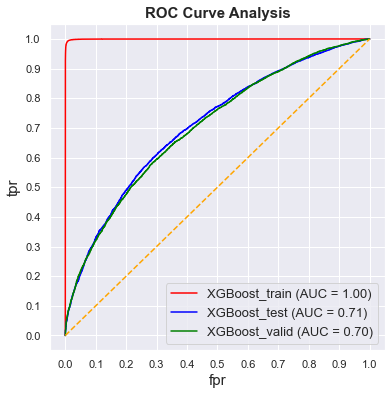

In [36]:
# Plot the figure:
fig, ax = plt.subplots(figsize=(6,6))

plot_roc_curve(best_dask_rscv, X_train, y_train, color='red', ax=ax, name='XGBoost_train')
plot_roc_curve(best_dask_rscv, X_test, y_test, color='blue', ax=ax, name='XGBoost_test')
plot_roc_curve(best_dask_rscv, X_valid, y_valid, color='green', ax=ax, name='XGBoost_valid')
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("fpr", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("tpr", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

## Plotting

### Feature importance (data)

In [37]:
# Let's build a dictionary to better see each INFORMATIVE feature with its corresponding importance:
feature_importance_dict = dict(zip(X_train.columns, best_dask_rscv.feature_importances_))
feature_importance_df = pd.DataFrame(feature_importance_dict.items(), columns=['Feature', 'Importance']) \
                          .sort_values(by='Importance', ascending=False)
feature_importance_df = feature_importance_df[feature_importance_df['Importance'] != 0]
feature_importance_df

,Feature,Importance
9,ARR_TIME_hour,0.078071
14,HourlyPrecipitation_Origin,0.063304
17,HourlyVisibility_Origin,0.055736
6,DEP_TIME_hour,0.055383
20,HourlyPrecipitation_Dest,0.054018
0,MONTH,0.044312
5,DEST,0.042423
3,OP_UNIQUE_CARRIER,0.041696
4,ORIGIN,0.041217
15,HourlyRelativeHumidity_Origin,0.039793


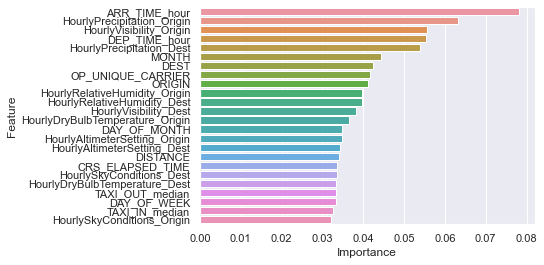

In [38]:
sns.barplot(y='Feature', x='Importance', data=feature_importance_df, orient='h');

### Permutation Feature Importance

In [39]:
# Source: https://machinelearningmastery.com/calculate-feature-importance-with-python/

from sklearn.inspection import permutation_importance

# perform permutation importance
results = permutation_importance(best_dask_rscv, X_train, y_train, scoring='f1')
# get importance
importance = dict(zip(X_train.columns, results.importances_mean))
permutation_importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Permutation_Importance']) \
                          .sort_values(by='Permutation_Importance', ascending=False)
permutation_importance_df = permutation_importance_df[permutation_importance_df['Permutation_Importance'] != 0]
permutation_importance_df

,Feature,Permutation_Importance
4,ORIGIN,0.078619
21,HourlyRelativeHumidity_Dest,0.063117
15,HourlyRelativeHumidity_Origin,0.058821
5,DEST,0.058718
9,ARR_TIME_hour,0.054179
0,MONTH,0.045297
13,HourlyDryBulbTemperature_Origin,0.036522
6,DEP_TIME_hour,0.035882
12,HourlyAltimeterSetting_Origin,0.035458
3,OP_UNIQUE_CARRIER,0.035073


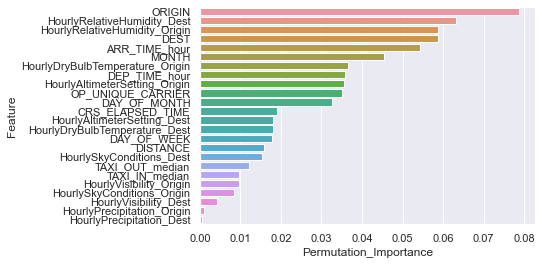

In [40]:
sns.barplot(y='Feature', x='Permutation_Importance', data=permutation_importance_df, orient='h');

### Feature importance (plot)

#### Weight-based

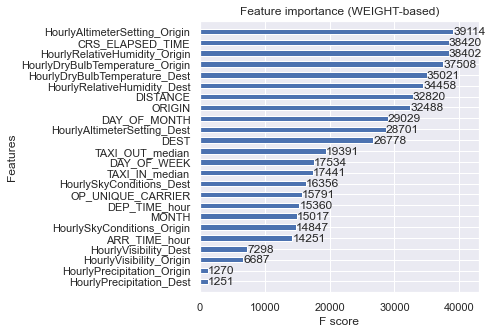

In [41]:
from xgboost import plot_importance

fig,ax = plt.subplots(figsize=(5,5))

plot_importance(booster=best_dask_rscv,
                ax=ax,
                grid=True,
                importance_type='weight', # ”weight” is the number of times a feature appears in a tree
                max_num_features=None, 
                height=0.5,
                xlim=None,
                ylim=None, 
                title='Feature importance (WEIGHT-based)',
                xlabel='F score',
                ylabel='Features',
                show_values=True);

#### Gain-based

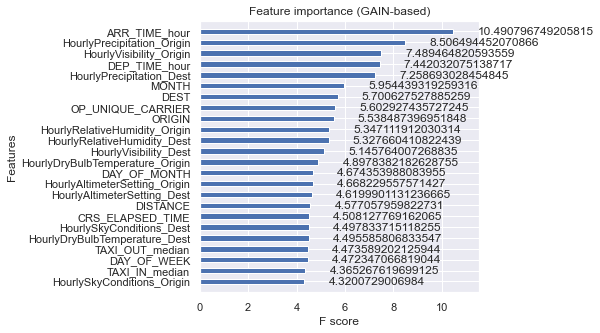

In [42]:
from xgboost import plot_importance

fig,ax = plt.subplots(figsize=(5,5))

plot_importance(booster=best_dask_rscv,
                ax=ax,
                grid=True,
                importance_type='gain',
                max_num_features=None, 
                height=0.5,
                xlim=None,
                ylim=None, 
                title='Feature importance (GAIN-based)',
                xlabel='F score',
                ylabel='Features',
                show_values=True);

### Tree

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0571745 to fit


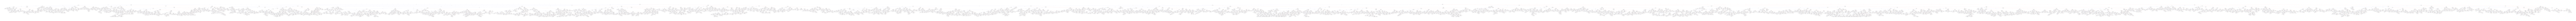

In [43]:
from xgboost import plot_tree

fig,ax = plt.subplots(figsize=(80,50))

plot_tree(booster=best_dask_rscv,
          num_trees=0,
          ax=ax)

plt.savefig('plot_tree_23_best_dask_rscv.png')

### Graphviz (tree)

*Convert specified tree to graphviz instance. IPython can automatically plot the returned graphiz instance. Otherwise, you should call `.render()` method of the returned graphiz instance.*

In [44]:
from xgboost import to_graphviz

tree_graphviz = to_graphviz(booster=best_dask_rscv,
                            yes_color='#0000FF',
                            no_color='#FF0000',
                            condition_node_params={'shape': 'box',
                                                   'style': 'filled,rounded',
                                                   'fillcolor': '#78bceb'},
                            leaf_node_params={'shape': 'box',
                                              'style': 'filled',
                                              'fillcolor': '#e48038'})

format = 'png'
tree_graphviz = to_graphviz(best_dask_rscv)
tree_graphviz.graph_attr = {'dpi':'400'}
tree_graphviz.render('tree_graphviz_23_best_dask_rscv', format = format)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0571745 to fit


'tree_graphviz_23_best_dask_rscv.png'

___

In [45]:
t1 = time.perf_counter() - t0
print("Time elapsed: {:2.0f}h {:2.0f}min {:2.0f}s".format(t1//3600, (t1%3600)//60, (t1%3600)%60))

Time elapsed:  0h 37min  7s


## Save the model

In [46]:
from joblib import dump, load

# Save model to file:
dump(best_dask_rscv, "XGBoost_23_best_dask_rscv.joblib.dat")
print("Saved model to: XGBoost_23_best_dask_rscv.joblib.dat")

Saved model to: XGBoost_23_best_dask_rscv.joblib.dat


In [47]:
# Load model from file:
loaded_model = load("XGBoost_23_best_dask_rscv.joblib.dat")
print("Loaded model from: XGBoost_23_best_dask_rscv.joblib.dat")

Loaded model from: XGBoost_23_best_dask_rscv.joblib.dat


In [48]:
# Make predictions for test data
predictions = loaded_model.predict(X_test)

# Evaluate predictions:
recall = recall_score(y_test, predictions)
print("Loaded model recall: {:6.3f}".format(recall))

Loaded model recall:  0.652


___

___